# 트랜스포머로 만드는 대화형 챗봇
- 영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.


### **루브릭 평가 기준**

|<center>평가문항</center>|<center>상세기준</center>|
|:------|:------|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|

# Step 1. 데이터 수집하기
- 송영숙님이 공개한 챗봇 데이터를 사용
[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import csv
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

- 멀티 헤드 어텐션을 구현
- 내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### 마스킹

In [5]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [6]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### 인코더

In [7]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [8]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더

In [9]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [10]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [11]:
path_to_dataset = os.getenv("HOME")+"/aiffel/transformer_chatbot/data/ChatbotData .csv"
path_to_conversations = path_to_dataset
path_to_conversations

'/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv'

In [12]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 30000
print(MAX_SAMPLES)

30000


# Step 2. 데이터 전처리하기
- 한글이므로 전처리 과정에 한글도 포함 
- 숫자도 포함 

In [13]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  # sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  # 한글, 알파벳, 숫자, 
  sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [14]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    with open(path_to_conversations, 'r') as file:
        lines = file.readlines()
        
    conversation = []
    for line in lines[1:]:
        parts = line.split(',')
        conversation.append([line for line in parts[0:2]])

        
    for i in range(len(conversation) - 1):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(conversation[i][0]))
        outputs.append(preprocess_sentence(conversation[i][1]))

    if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs

    return inputs, outputs

In [15]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11822
전체 샘플 수 : 11822


In [16]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


# Step 3. SubwordTextEncoder 사용하기

In [17]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [18]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8138]
END_TOKEN의 번호 : [8139]


In [19]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8140


In [20]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5736, 607, 2478, 4139]
정수 인코딩 후의 21번째 답변 샘플: [2347, 7482, 7, 6245, 96, 1]


### 익스 8번 뉴스 요약 코드 참고
- 거의 포함 될 수 있는 길이 11로 세팅 

In [21]:
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]
print(f'questions 최대 길이 : {np.max(questions_len)}')
print(f'questions 평균 길이 : {np.mean(questions_len)}')
print(f'answers 최대 길이 : {np.max(answers_len)}')
print(f'answers 평균 길이 : {np.mean(answers_len)}')

questions 최대 길이 : 16
questions 평균 길이 : 3.9260700389105057
answers 최대 길이 : 24
answers 평균 길이 : 4.685078666892235


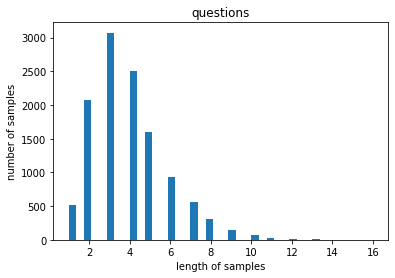

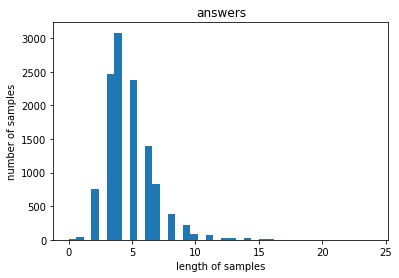

In [22]:
plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
# 최대 허용 길이 지정
MAX_LENGTH = 11

In [24]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [25]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8140
필터링 후의 질문 샘플 개수: 10166
필터링 후의 답변 샘플 개수: 10166


교사 강요(Teacher Forcing) 사용하기

In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Step 4. 모델 구성하기

트랜스포머 함수 정의

In [27]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

모델 생성

In [28]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3138048     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

손실 함수

In [29]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

커스텀 된 학습률(Learning rate)

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

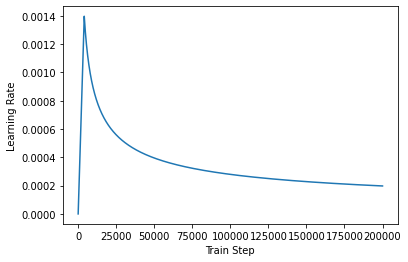

In [31]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

모델 컴파일

In [32]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [33]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
159/159 [==============================] - 11s 29ms/step - loss: 5.2117 - accuracy: 0.0900
Epoch 2/20
159/159 [==============================] - 5s 29ms/step - loss: 4.2906 - accuracy: 0.1890
Epoch 3/20
159/159 [==============================] - 5s 29ms/step - loss: 3.5747 - accuracy: 0.1936
Epoch 4/20
159/159 [==============================] - 5s 29ms/step - loss: 3.2560 - accuracy: 0.2016
Epoch 5/20
159/159 [==============================] - 5s 29ms/step - loss: 3.0603 - accuracy: 0.2131
Epoch 6/20
159/159 [==============================] - 5s 29ms/step - loss: 2.8720 - accuracy: 0.2241
Epoch 7/20
159/159 [==============================] - 5s 29ms/step - loss: 2.6703 - accuracy: 0.2421
Epoch 8/20
159/159 [==============================] - 5s 28ms/step - loss: 2.4419 - accuracy: 0.2670
Epoch 9/20
159/159 [==============================] - 5s 28ms/step - loss: 2.1896 - accuracy: 0.2976
Epoch 10/20
159/159 [==============================] - 5s 29ms/step - loss: 1.9258 - accur

# Step 5. 모델 평가하기

In [34]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331  86  30  5  1059  7  8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [35]:
# 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 함수
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [36]:
sentence_generation('내일 날씨는 어때?')
sentence_generation('어떤 영화 좋아해?')
sentence_generation('오늘 뭐먹지?')
sentence_generation('피곤하고 잠와')
sentence_generation('사랑해')

입력 : 내일 날씨는 어때?
출력 : 사랑이 깊이 생각하지 말아요 .
입력 : 어떤 영화 좋아해?
출력 : 영화는 데이트의 기본이죠 .
입력 : 오늘 뭐먹지?
출력 : 정확하게 말씀해 주세요 .
입력 : 피곤하고 잠와
출력 : 사람은 외로운 동물이죠 .
입력 : 사랑해
출력 : 상대방에게 전해보세요 .


'상대방에게 전해보세요 .'

# 두번째 시도 
- D_MODEL = 512
- DROPOUT = 0.5

In [37]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.5 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    7323648     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [39]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
159/159 [==============================] - 12s 40ms/step - loss: 5.0963 - accuracy: 0.0753
Epoch 2/20
159/159 [==============================] - 6s 40ms/step - loss: 4.0158 - accuracy: 0.1588
Epoch 3/20
159/159 [==============================] - 6s 40ms/step - loss: 3.5338 - accuracy: 0.1927
Epoch 4/20
159/159 [==============================] - 6s 40ms/step - loss: 3.3979 - accuracy: 0.1945
Epoch 5/20
159/159 [==============================] - 6s 40ms/step - loss: 3.2878 - accuracy: 0.1968
Epoch 6/20
159/159 [==============================] - 6s 40ms/step - loss: 3.1926 - accuracy: 0.2024
Epoch 7/20
159/159 [==============================] - 6s 40ms/step - loss: 3.0988 - accuracy: 0.2088
Epoch 8/20
159/159 [==============================] - 6s 40ms/step - loss: 3.0023 - accuracy: 0.2142
Epoch 9/20
159/159 [==============================] - 6s 40ms/step - loss: 2.8864 - accuracy: 0.2214
Epoch 10/20
159/159 [==============================] - 6s 40ms/step - loss: 2.7514 - accur

In [40]:
sentence_generation('내일 날씨는 어때?')
sentence_generation('어떤 영화 좋아해?')
sentence_generation('오늘 뭐먹지?')
sentence_generation('피곤하고 잠와')
sentence_generation('사랑해')

입력 : 내일 날씨는 어때?
출력 : 혼자 풀릴 때까지 놔둬야하는데 기다리는게 힘들 거예요 .
입력 : 어떤 영화 좋아해?
출력 : 아무래도 그렇죠 .
입력 : 오늘 뭐먹지?
출력 : 혼자 힘들어하지 마세요 .
입력 : 피곤하고 잠와
출력 : 저도 듣고 싶어요 .
입력 : 사랑해
출력 : 좋은 소식이네요 .


'좋은 소식이네요 .'

# 세번째 시도 
- DROPOUT = 0.5
- EPOCHS =50

In [41]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.5 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3138048     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [42]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
159/159 [==============================] - 10s 29ms/step - loss: 5.1866 - accuracy: 0.0959
Epoch 2/50
159/159 [==============================] - 5s 29ms/step - loss: 4.2965 - accuracy: 0.1877
Epoch 3/50
159/159 [==============================] - 5s 29ms/step - loss: 3.5956 - accuracy: 0.1935
Epoch 4/50
159/159 [==============================] - 5s 29ms/step - loss: 3.2685 - accuracy: 0.2011
Epoch 5/50
159/159 [==============================] - 5s 29ms/step - loss: 3.0661 - accuracy: 0.2124
Epoch 6/50
159/159 [==============================] - 5s 29ms/step - loss: 2.8762 - accuracy: 0.2243
Epoch 7/50
159/159 [==============================] - 5s 29ms/step - loss: 2.6690 - accuracy: 0.2424
Epoch 8/50
159/159 [==============================] - 5s 29ms/step - loss: 2.4464 - accuracy: 0.2664
Epoch 9/50
159/159 [==============================] - 5s 29ms/step - loss: 2.1964 - accuracy: 0.2959
Epoch 10/50
159/159 [==============================] - 5s 29ms/step - loss: 1.9289 - accur

In [43]:
sentence_generation('내일 날씨는 어때?')
sentence_generation('어떤 영화 좋아해?')
sentence_generation('오늘 뭐먹지?')
sentence_generation('피곤하고 잠와')
sentence_generation('사랑해')

입력 : 내일 날씨는 어때?
출력 : 정말 후회할 습관이에요 .
입력 : 어떤 영화 좋아해?
출력 : 성적자기결정권이있죠 .
입력 : 오늘 뭐먹지?
출력 : 색다른걸 드셔보세요 .
입력 : 피곤하고 잠와
출력 : 믿기지 않겠어요 .
입력 : 사랑해
출력 : 하늘 만큼 땅 만큼 사랑해요 .


'하늘 만큼 땅 만큼 사랑해요 .'

# 네번째 시도
- NUM_LAYERS = 4
- DROPOUT = 0.3
- EPOCHS = 50

In [44]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.3 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4192256     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [45]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
159/159 [==============================] - 18s 48ms/step - loss: 5.1957 - accuracy: 0.0775
Epoch 2/50
159/159 [==============================] - 8s 48ms/step - loss: 4.3864 - accuracy: 0.1228
Epoch 3/50
159/159 [==============================] - 8s 48ms/step - loss: 3.6739 - accuracy: 0.1923
Epoch 4/50
159/159 [==============================] - 8s 49ms/step - loss: 3.4135 - accuracy: 0.1939
Epoch 5/50
159/159 [==============================] - 8s 48ms/step - loss: 3.2504 - accuracy: 0.1996
Epoch 6/50
159/159 [==============================] - 8s 48ms/step - loss: 3.1470 - accuracy: 0.2052
Epoch 7/50
159/159 [==============================] - 8s 48ms/step - loss: 3.0587 - accuracy: 0.2087
Epoch 8/50
159/159 [==============================] - 8s 48ms/step - loss: 2.9730 - accuracy: 0.2126
Epoch 9/50
159/159 [==============================] - 8s 49ms/step - loss: 2.8870 - accuracy: 0.2167
Epoch 10/50
159/159 [==============================] - 8s 48ms/step - loss: 2.7954 - accur

In [46]:
sentence_generation('내일 날씨는 어때?')
sentence_generation('어떤 영화 좋아해?')
sentence_generation('오늘 뭐먹지?')
sentence_generation('피곤하고 잠와')
sentence_generation('사랑해')

입력 : 내일 날씨는 어때?
출력 : 다른 사람이 답답할 거예요 .
입력 : 어떤 영화 좋아해?
출력 : 사람마다 다르겠지만 사귀고 난 후가 좋겠어요 .
입력 : 오늘 뭐먹지?
출력 : 하다보면 늘어요 .
입력 : 피곤하고 잠와
출력 : 같이 고르는 것도 좋을 거 같아요 .
입력 : 사랑해
출력 : 저도 보고 싶어요 .


'저도 보고 싶어요 .'

# 다섯번째 시도
- UNITS = 1024
- DROPOUT = 0.5
- EPOCHS = 30

In [47]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.5 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3663360     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [48]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
159/159 [==============================] - 10s 30ms/step - loss: 5.2599 - accuracy: 0.0687
Epoch 2/30
159/159 [==============================] - 5s 29ms/step - loss: 4.4050 - accuracy: 0.1321
Epoch 3/30
159/159 [==============================] - 5s 29ms/step - loss: 3.7021 - accuracy: 0.1914
Epoch 4/30
159/159 [==============================] - 5s 29ms/step - loss: 3.4663 - accuracy: 0.1937
Epoch 5/30
159/159 [==============================] - 5s 29ms/step - loss: 3.3289 - accuracy: 0.1958
Epoch 6/30
159/159 [==============================] - 5s 29ms/step - loss: 3.2170 - accuracy: 0.1989
Epoch 7/30
159/159 [==============================] - 5s 29ms/step - loss: 3.1302 - accuracy: 0.2048
Epoch 8/30
159/159 [==============================] - 5s 29ms/step - loss: 3.0456 - accuracy: 0.2105
Epoch 9/30
159/159 [==============================] - 5s 29ms/step - loss: 2.9556 - accuracy: 0.2152
Epoch 10/30
159/159 [==============================] - 5s 29ms/step - loss: 2.8565 - accur

In [50]:
sentence_generation('내일 날씨는 어때?')
sentence_generation('어떤 영화 좋아해?')
sentence_generation('오늘 뭐 먹지?')
sentence_generation('피곤하고 잠와')
sentence_generation('사랑해')

입력 : 내일 날씨는 어때?
출력 : 저도 반가워요 .
입력 : 어떤 영화 좋아해?
출력 : 직접 물어보는 게 좋을 것 같아요 .
입력 : 오늘 뭐 먹지?
출력 : 감기 조심하세요 .
입력 : 피곤하고 잠와
출력 : 직장 스트레스가 심한가봐요 .
입력 : 사랑해
출력 : 저도 커피 좋아해요 .


'저도 커피 좋아해요 .'

# 여섯번째 시도 
- NUM_LAYERS = 4
- D_MODEL = 512
- DROPOUT = 0.5
- EPOCHS = 30

In [51]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.5 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    10479616    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [52]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
159/159 [==============================] - 21s 65ms/step - loss: 5.0382 - accuracy: 0.0732
Epoch 2/30
159/159 [==============================] - 10s 64ms/step - loss: 4.0648 - accuracy: 0.1032
Epoch 3/30
159/159 [==============================] - 10s 64ms/step - loss: 3.5925 - accuracy: 0.1889
Epoch 4/30
159/159 [==============================] - 10s 64ms/step - loss: 3.4297 - accuracy: 0.1937
Epoch 5/30
159/159 [==============================] - 10s 64ms/step - loss: 3.3137 - accuracy: 0.1951
Epoch 6/30
159/159 [==============================] - 10s 64ms/step - loss: 3.2328 - accuracy: 0.1972
Epoch 7/30
159/159 [==============================] - 10s 64ms/step - loss: 3.1797 - accuracy: 0.1989
Epoch 8/30
159/159 [==============================] - 10s 64ms/step - loss: 3.1349 - accuracy: 0.2024
Epoch 9/30
159/159 [==============================] - 10s 64ms/step - loss: 3.0874 - accuracy: 0.2041
Epoch 10/30
159/159 [==============================] - 10s 64ms/step - loss: 3.034

In [53]:
sentence_generation('내일 날씨는 어때?')
sentence_generation('어떤 영화 좋아해?')
sentence_generation('오늘 뭐 먹지?')
sentence_generation('피곤하고 잠와')
sentence_generation('사랑해')

입력 : 내일 날씨는 어때?
출력 : 너무 충분히 많이 바쁜가봐요 .
입력 : 어떤 영화 좋아해?
출력 : 썸 나이는 중요하지 않아요 .
입력 : 오늘 뭐 먹지?
출력 : 제가 있잖아요 .
입력 : 피곤하고 잠와
출력 : 잘 다녀 오세요 .
입력 : 사랑해
출력 : 너무 충분히 많이 바쁜가봐요 .


'너무 충분히 많이 바쁜가봐요 .'

# 일곱번째 시도
1번과 동일하고 
EPOCHS = 50

In [54]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3138048     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [55]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
159/159 [==============================] - 10s 29ms/step - loss: 5.2426 - accuracy: 0.1041
Epoch 2/50
159/159 [==============================] - 4s 28ms/step - loss: 4.3201 - accuracy: 0.1912
Epoch 3/50
159/159 [==============================] - 4s 28ms/step - loss: 3.5931 - accuracy: 0.1935
Epoch 4/50
159/159 [==============================] - 4s 28ms/step - loss: 3.2648 - accuracy: 0.2012
Epoch 5/50
159/159 [==============================] - 4s 28ms/step - loss: 3.0653 - accuracy: 0.2125
Epoch 6/50
159/159 [==============================] - 4s 28ms/step - loss: 2.8751 - accuracy: 0.2255
Epoch 7/50
159/159 [==============================] - 4s 28ms/step - loss: 2.6771 - accuracy: 0.2423
Epoch 8/50
159/159 [==============================] - 4s 28ms/step - loss: 2.4551 - accuracy: 0.2659
Epoch 9/50
159/159 [==============================] - 4s 28ms/step - loss: 2.2079 - accuracy: 0.2936
Epoch 10/50
159/159 [==============================] - 4s 28ms/step - loss: 1.9379 - accur

In [56]:
sentence_generation('내일 날씨는 어때?')
sentence_generation('어떤 영화 좋아해?')
sentence_generation('오늘 뭐 먹지?')
sentence_generation('피곤하고 잠와')
sentence_generation('사랑해')

입력 : 내일 날씨는 어때?
출력 : 조금씩 조금씩 해보세요 .
입력 : 어떤 영화 좋아해?
출력 : 최신 영화가 좋을 것 같아요 .
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
입력 : 피곤하고 잠와
출력 : 같은 하늘 아래 어딘가에 .
입력 : 사랑해
출력 : 하늘 만큼 땅 만큼 사랑해요 .


'하늘 만큼 땅 만큼 사랑해요 .'

# 회고
- 처음에 돌렸을 때는 괜찮은 결과가 나왔는데 Restart로 전체로 다시 돌리니 이상하게 나와서 당황스러웠음 처음 나온건 이것보다 잘 나왔는데 똑같이 나와야지 왜 바뀌어서 다른 문장이 나오는지 이해가 되지 않음. 
- 한국어에 맞게 데이터 전처리를 해봄(조원들이 숫자까지 얘기해줘서 숫자도 전처리에 넣음)
- 뉴스요약 익스에서 사용했던 코드를 그대로 가져와서 문장 길이를 보면서 MAX_LENGTH의 기준을 잡을 때 도움이 됨
- 다른 길이로는 안해보고 11로만 했는데 길이가 달라짐에 따라 결과물도 많이 달라진다는 것을 성돈님께 듣게 되었고, 11로 했을 때 결과물이 괜찮았다고 해주셨다. 다행히 처음에 기준을 잘 잡아서 실행한 것 같다. 
- 위에 결과를 봤을 때 그닥 확 마음에 들지는 않았는데 이게 괜찮은 결과물이라니 나름 괜찮게 대답한것도 있지만 수정이 많이 필요하다. 